# Satellite Imagery

In this section we turn to **raster** data, specifically, to satellite imagery.  

In [55]:
import ibis
from ibis import _
con = ibis.duckdb.connect()

redlines = (con
            .read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
            .filter(_.city == "New Haven")
            .execute()
           )
box = redlines.total_bounds
box

array([-72.99321,  41.23109, -72.85227,  41.37502])

In [63]:
from pystac_client import Client
import odc.stac
import pystac_client
import rioxarray
import geopandas as gpd
from rasterstats import zonal_stats 
import dask
workers = dask.distributed.Client()


In [64]:
items = (
  Client.
  open("https://earth-search.aws.element84.com/v1").
  search(
    collections = ['sentinel-2-l2a'],
    bbox = box,
    datetime = "2024-06-01/2024-08-01",
    query={"eo:cloud_cover": {"lt": 5}}).
  item_collection()
)

In [25]:
items

In [65]:
data = odc.stac.load(
    items,
    bands=["nir08", "red"],
    bbox=box,
    chunks = {}
)

In [67]:
ndvi = (
    ((data.nir08 - data.red) / (data.red + data.nir08))
    #.resample("time")
    .median("time", keep_attrs=True)
    .compute()
)

ndvi = ndvi.where(ndvi < 1)




In [61]:
ndvi

<xarray.DataArray (y: 1627, x: 1220)> Size: 16MB
array([[0.89578284, 0.90170044, 0.89993018, ..., 0.86543046, 0.84877921,
        0.86216156],
       [0.86905615, 0.89684015, 0.9254717 , ..., 0.78368794, 0.84442116,
        0.82260184],
       [0.88749419, 0.91292991, 0.92634809, ..., 0.82636656, 0.85994962,
        0.8420828 ],
       ...,
       [0.85421745, 0.53955136, 0.44247788, ...,        nan,        nan,
               nan],
       [0.89298158, 0.52336449, 0.46957175, ...,        nan,        nan,
               nan],
       [0.86834942, 0.49810207, 0.46052632, ...,        nan,        nan,
               nan]])
Coordinates:
  * y            (y) float64 13kB 4.583e+06 4.583e+06 ... 4.566e+06 4.566e+06
  * x            (x) float64 10kB 6.678e+05 6.678e+05 ... 6.8e+05 6.8e+05
    spatial_ref  int32 4B 32618

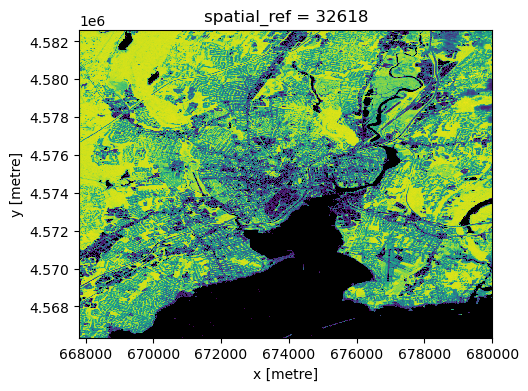

In [68]:
import matplotlib as plt
cmap = plt.colormaps.get_cmap('viridis')  # viridis is the default colormap for imshow
cmap.set_bad(color='black')

ndvi.plot.imshow( cmap=cmap, add_colorbar=False, size=4)